In [3]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.18 ms


## Imports & Settings

In [4]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix, roc_auc_score,
                             plot_roc_curve)
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 5.41 s


## Creating The Database

In [5]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.48 ms


**Run The Cell Below Once And Then Comment Out**

In [6]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 756 µs


### Database ERD

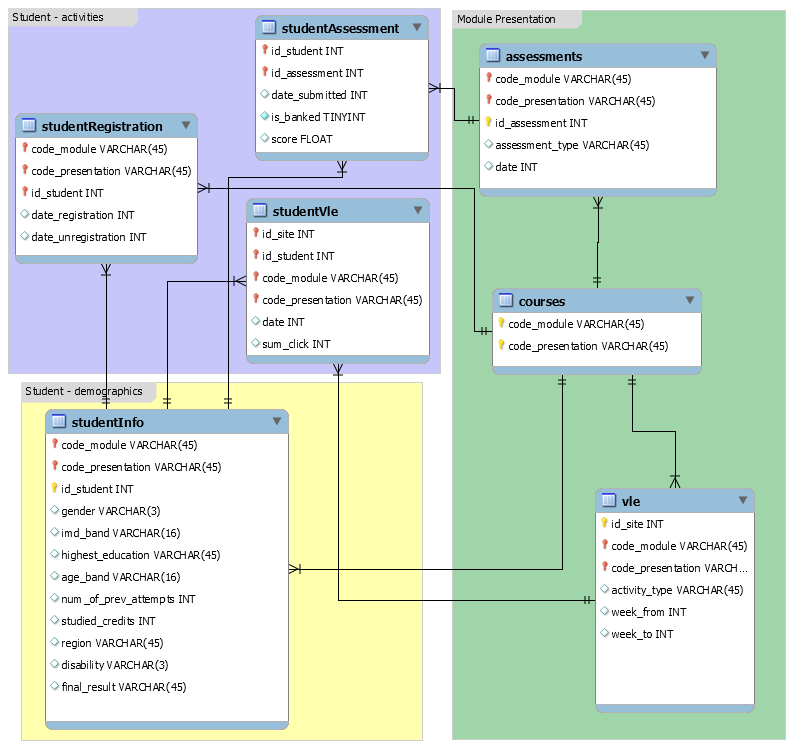

time: 3.89 ms


In [7]:
db.erd

## Preprocessing and Harness Objects

In [8]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.61 ms


In [9]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 4.07 ms


## Half Term Data

In [10]:
# database_name = 'outcomes.db'
# db_new = db.Database(database_name)

time: 644 µs


In [11]:
df = db.data_prep(120)

time: 11.4 s


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24770 entries, 0 to 24769
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target                23261 non-null  float64
 1   row_id                24770 non-null  object 
 2   score                 23237 non-null  object 
 3   gender                23261 non-null  object 
 4   region                23261 non-null  object 
 5   highest_education     23261 non-null  object 
 6   imd_band              22335 non-null  object 
 7   age_band              23261 non-null  object 
 8   num_of_prev_attempts  23261 non-null  object 
 9   studied_credits       23261 non-null  float64
 10  disability            23261 non-null  object 
 11  final_result          23261 non-null  object 
 12  date_sub              23261 non-null  float64
 13  course_length         23261 non-null  float64
 14  weighted_ave          23255 non-null  float64
 15  mean_score         

In [13]:
df.describe()

,target,studied_credits,date_sub,course_length,weighted_ave,mean_score,median_score,sum_activity,max_date,date_registration,date_unregistration
count,23261.000000,23261.000000,23261.000000,23261.000000,23255.000000,23255.000000,23255.000000,23261.000000,23261.000000,24770.000000,2255.000000
mean,0.340398,75.350802,25.388074,239.679249,115.535241,75.167841,75.520490,1184.305791,-8.732514,-65.488736,170.795565
std,0.473853,37.119805,14.408581,5.617692,72.955003,15.072363,15.022744,1259.735843,11.380161,47.117116,33.475645
min,0.000000,30.000000,-11.000000,234.000000,0.000000,0.000000,0.000000,2.000000,-25.000000,-311.000000,121.000000
25%,0.000000,60.000000,18.000000,240.000000,67.200000,67.428571,67.500000,378.000000,-17.000000,-94.000000,144.000000
50%,0.000000,60.000000,21.000000,240.000000,120.240000,78.285714,78.000000,786.000000,-10.000000,-52.000000,165.000000
75%,1.000000,90.000000,31.000000,241.000000,160.000000,86.000000,86.000000,1518.000000,-4.000000,-29.000000,198.000000
max,1.000000,630.000000,119.000000,268.000000,663.660000,100.000000,100.000000,15828.000000,117.000000,167.000000,444.000000


time: 57.9 ms


In [14]:
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration', 'max_date']

time: 1.04 ms


In [15]:
df = db.pipe_cleaner_wa(df, drops)

time: 64.8 ms


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20856 entries, 1 to 24769
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                20856 non-null  float64 
 1   gender                20856 non-null  object  
 2   region                20856 non-null  object  
 3   highest_education     20856 non-null  object  
 4   imd_band              20856 non-null  object  
 5   age_band              20856 non-null  object  
 6   num_of_prev_attempts  20856 non-null  object  
 7   disability            20856 non-null  object  
 8   weighted_ave          20856 non-null  float64 
 9   mean_score            20856 non-null  float64 
 10  median_score          20856 non-null  float64 
 11  sum_activity          20856 non-null  float64 
 12  course_load           20856 non-null  category
dtypes: category(1), float64(5), object(7)
memory usage: 2.1+ MB
time: 18.8 ms


In [17]:
df.target.value_counts(normalize=True)

0.0    0.657796
1.0    0.342204
Name: target, dtype: float64

time: 3.65 ms


## Creating Holdout Data

In [18]:
# splitting data & target
X, y = f.X_y(df)

time: 3.17 ms


In [19]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 12.5 ms


## Creating Training Data

In [20]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 9.58 ms


## Baseline Model: Dummy Classifier

In [21]:
dummy = DummyClassifier(strategy='most_frequent')

time: 889 µs


In [22]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 905 µs


### Fitting Model

In [23]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 43.9 ms


### Saving Model

In [24]:
# f.pickle_model(baseline, 'baseline')

time: 708 µs


### Cross Val Scores

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.6577444278687744
 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0
time: 229 ms


### Test Data Confusion Matrix

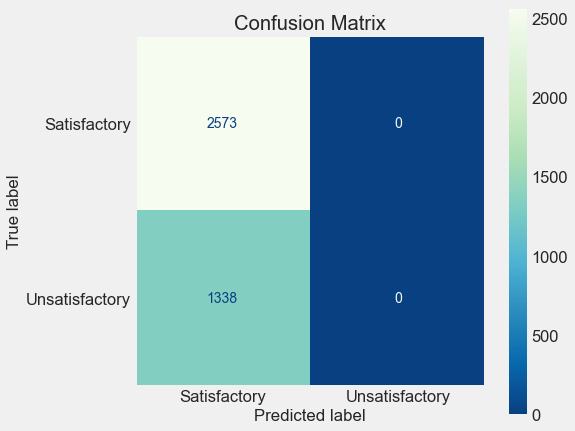

,Accuracy,F1,Recall,Precision
0,0.657888,0.0,0.0,0.0


time: 314 ms


In [26]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## First Simple Model: Naive Bayes Classifier

In [27]:
mnb = MultinomialNB()

time: 689 µs


In [28]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 1.32 ms


### Fitting Model

In [29]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>)])),
                ('multinomialnb', MultinomialNB())])

time: 49.5 ms


### Saving Model

In [30]:
# f.pickle_model(fsm, 'fsm')

time: 591 µs


### Cross Val Scores

In [31]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.6661843982141865
 fsm has an average F1 of 0.2871061484619165
 fsm has an average Recall of 0.19651307596513073
 fsm has an average Precision of 0.5350169736278166


[0.6661843982141865,
 0.2871061484619165,
 0.19651307596513073,
 0.5350169736278166]

time: 220 ms


### Test Data Confusion Matrix

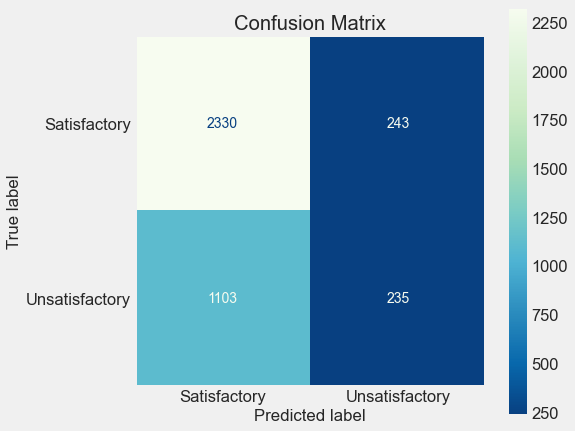

,Accuracy,F1,Recall,Precision
0,0.655842,0.258811,0.175635,0.491632


time: 342 ms


In [32]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

# Standard Scaling

## KNeighborsClassifier

In [33]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 753 µs


In [34]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 1.06 ms


### Fitting Model

In [35]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 59.7 ms


In [36]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 755 µs


### Cross Val Scores

In [37]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.7227859766199509
knn_ss has an average F1 of 0.5527863564206983
knn_ss has an average Recall of 0.5006226650062267
knn_ss has an average Precision of 0.6172131836928612


[0.7227859766199509,
 0.5527863564206983,
 0.5006226650062267,
 0.6172131836928612]

time: 4.25 s


### Test Data Confusion Matrix

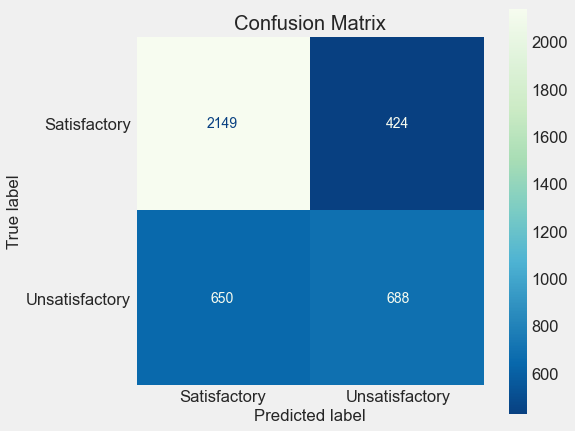

,Accuracy,F1,Recall,Precision
0,0.72539,0.561633,0.5142,0.618705


time: 8.44 s


In [38]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [39]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 880 µs


In [40]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 1.26 ms


### Fitting Model

In [41]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 3.64 s


In [42]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 1.4 ms


### Cross Val Scores

In [43]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.748273702693504
logreg_ss has an average F1 of 0.5732024966668636
logreg_ss has an average Recall of 0.49389788293897885
logreg_ss has an average Precision of 0.683257309943272


[0.748273702693504, 0.5732024966668636, 0.49389788293897885, 0.683257309943272]

time: 6.29 s


### Test Data Confusion Matrix

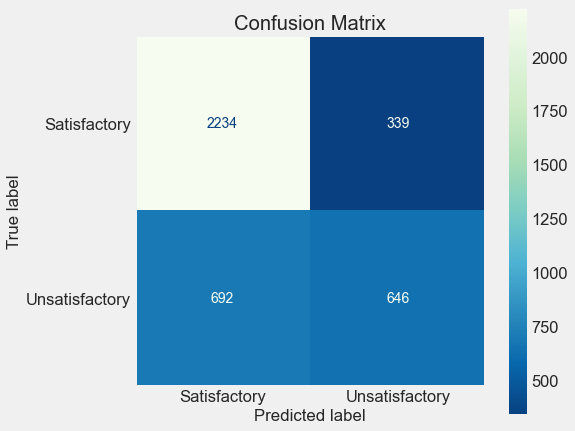

,Accuracy,F1,Recall,Precision
0,0.736385,0.556177,0.48281,0.655838


time: 212 ms


In [44]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [45]:
SVC = SVC()

time: 751 µs


In [46]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 1.25 ms


### Fitting Model

In [47]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('svc', SVC())])

time: 5.88 s


In [48]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 610 µs


### Cross Val Scores

In [49]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.7582472191559049
svc_ss has an average F1 of 0.5867290656339277
svc_ss has an average Recall of 0.5013698630136986
svc_ss has an average Precision of 0.7072729234993698


[0.7582472191559049,
 0.5867290656339277,
 0.5013698630136986,
 0.7072729234993698]

time: 21.9 s


### Test Data Confusion Matrix

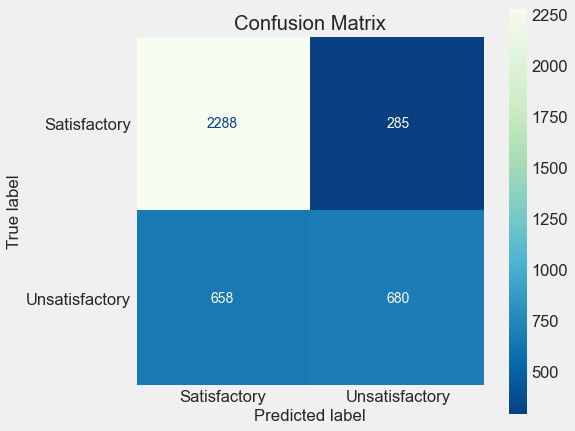

,Accuracy,F1,Recall,Precision
0,0.758885,0.590534,0.508221,0.704663


time: 6.45 s


In [50]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [51]:
LSVC = LinearSVC(random_state=2021)

time: 774 µs


In [52]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 956 µs


### Fitting Model

In [53]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('linearsvc', LinearSVC(random_state=2021))])

time: 652 ms


In [54]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 638 µs


### Cross Val Scores

In [55]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7473361542241987
lsvc_ss has an average F1 of 0.5649109964886151
lsvc_ss has an average Recall of 0.47920298879202994
lsvc_ss has an average Precision of 0.6885040206424522


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.7473361542241987,
 0.5649109964886151,
 0.47920298879202994,
 0.6885040206424522]

time: 2.6 s


### Test Data Confusion Matrix

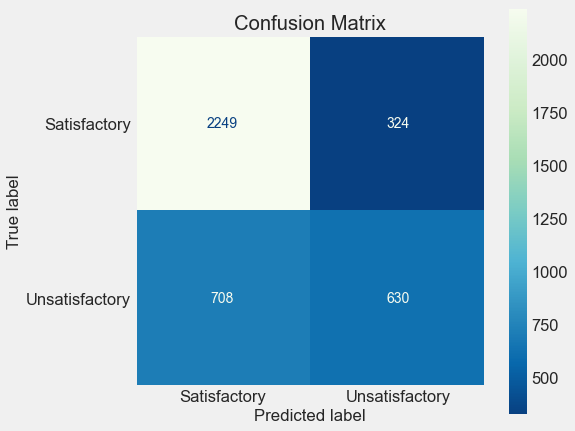

,Accuracy,F1,Recall,Precision
0,0.736129,0.549738,0.470852,0.660377


time: 219 ms


In [56]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [57]:
DT = DecisionTreeClassifier(random_state=2021)

time: 867 µs


In [58]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 984 µs


### Fitting Model

In [59]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 504 ms


In [60]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 648 µs


### Cross Val Scores

In [61]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.6911591260686858
dt_ss has an average F1 of 0.5519606477894271
dt_ss has an average Recall of 0.5561643835616439
dt_ss has an average Precision of 0.5482875659884845


[0.6911591260686858,
 0.5519606477894271,
 0.5561643835616439,
 0.5482875659884845]

time: 1.83 s


### Test Data Confusion Matrix

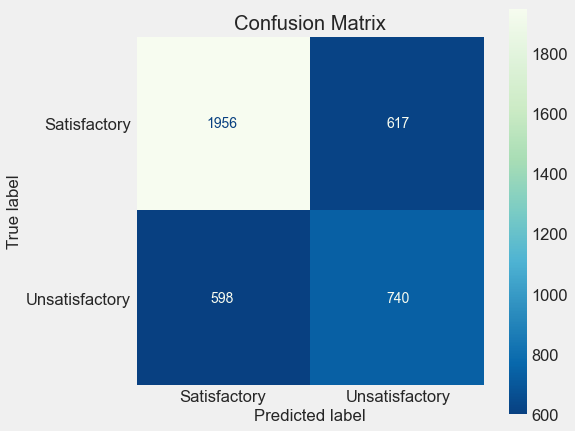

,Accuracy,F1,Recall,Precision
0,0.689338,0.549165,0.553064,0.545321


time: 232 ms


In [62]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [63]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 871 µs


In [64]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 957 µs


### Fitting Model

In [65]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.99 s


In [66]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 608 µs


### Cross Val Scores

In [67]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.7611454792917334
bclf_ss has an average F1 of 0.6039872130605164
bclf_ss has an average Recall of 0.5325031133250311
bclf_ss has an average Precision of 0.6980856957484987


[0.7611454792917334,
 0.6039872130605164,
 0.5325031133250311,
 0.6980856957484987]

time: 11.1 s


### Test Data Confusion Matrix

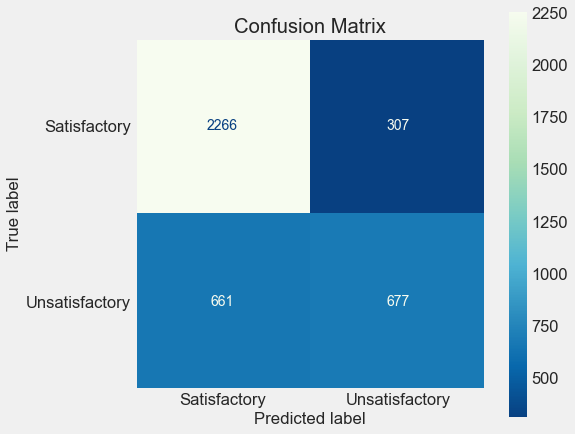

,Accuracy,F1,Recall,Precision
0,0.752493,0.583118,0.505979,0.688008


time: 291 ms


In [68]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [69]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 845 µs


In [70]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 1.12 ms


### Fitting Model

In [71]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.12 s


In [72]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 754 µs


### Cross Val Scores

In [73]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.7663451664728803
rf_ss has an average F1 of 0.6171628271801979
rf_ss has an average Recall of 0.5504358655043586
rf_ss has an average Precision of 0.7027435069899256


[0.7663451664728803,
 0.6171628271801979,
 0.5504358655043586,
 0.7027435069899256]

time: 9.84 s


### Test Data Confusion Matrix

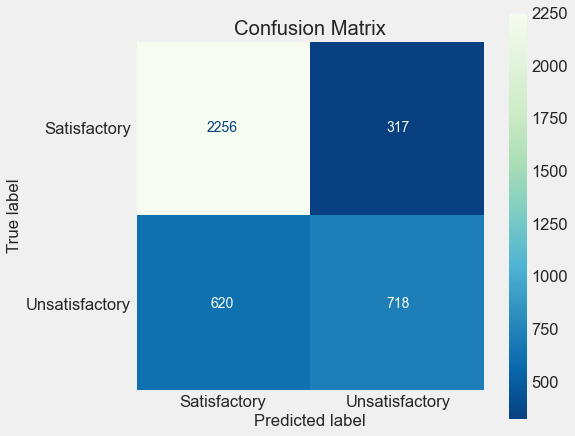

,Accuracy,F1,Recall,Precision
0,0.760419,0.605141,0.536622,0.69372


time: 486 ms


In [74]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [75]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 876 µs


In [76]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 1.35 ms


### Fitting Model

In [77]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 522 ms


In [78]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 680 µs


### Cross Val Scores

In [79]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.6923531191621163
ada_ss has an average F1 of 0.5532492214293872
ada_ss has an average Recall of 0.5566625155666252
ada_ss has an average Precision of 0.5501905859947283


[0.6923531191621163,
 0.5532492214293872,
 0.5566625155666252,
 0.5501905859947283]

time: 1.88 s


### Test Data Confusion Matrix

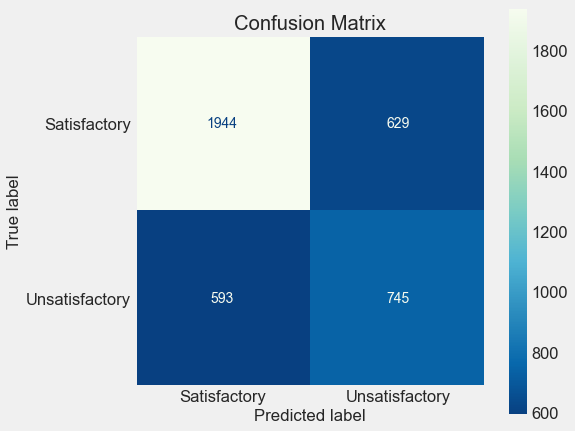

,Accuracy,F1,Recall,Precision
0,0.687548,0.54941,0.556801,0.542213


time: 233 ms


In [80]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [81]:
XGB = XGBClassifier(use_label_encoder=False, verbosity=0)

time: 909 µs


In [82]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 1.07 ms


### Fitting Model

In [83]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 833 ms


In [84]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 1.25 ms


### Cross Val Scores

In [85]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

[0.7700959052041186,
 0.6346968211393115,
 0.5835616438356165,
 0.6957747918397152]

time: 3.8 s


### Test Data Confusion Matrix

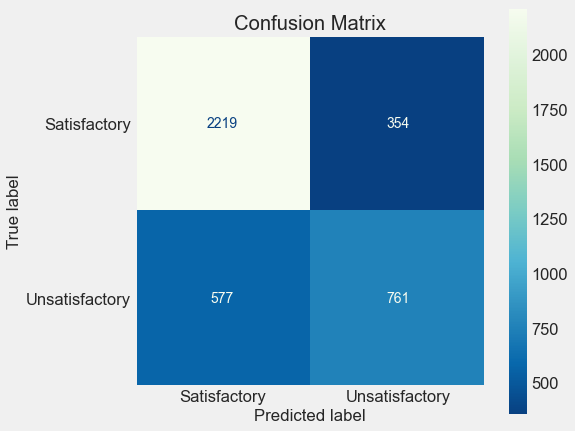

,Accuracy,F1,Recall,Precision
0,0.761953,0.620465,0.568759,0.682511


time: 351 ms


In [86]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary

In [87]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.657744,0.000000,0.000000,0.000000,0.225856,Baseline DummyCFL
1,fsm,0.666184,0.287106,0.196513,0.535017,0.215852,FSM Naive Bayes
2,lsvc_ss,0.747336,0.564911,0.479203,0.688504,2.591510,Linear SVC SS()
3,logreg_ss,0.748274,0.573202,0.493898,0.683257,6.288537,LogReg SS()
4,knn_ss,0.722786,0.552786,0.500623,0.617213,4.235443,KNN SS()
5,svc_ss,0.758247,0.586729,0.501370,0.707273,21.937422,Support Vector CLF SS()
6,bclf_ss,0.761145,0.603987,0.532503,0.698086,11.107266,Bagging CLF SS()
7,rf_ss,0.766345,0.617163,0.550436,0.702744,9.838081,Random Forest SS()
8,dt_ss,0.691159,0.551961,0.556164,0.548288,1.828373,Decision Tree CLF SS()
9,ada_ss,0.692353,0.553249,0.556663,0.550191,1.870478,AdaBoost SS()


time: 10.4 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [88]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

time: 1.16 ms


In [89]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 1.16 ms


### Fitting Model

In [90]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.26 s


In [91]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 737 µs


### Cross Val Scores

In [92]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

[0.7746137257444612, 0.638734616324627, 0.5823163138231632, 0.7075155716659335]

time: 20.4 s


### Test Data Confusion Matrix

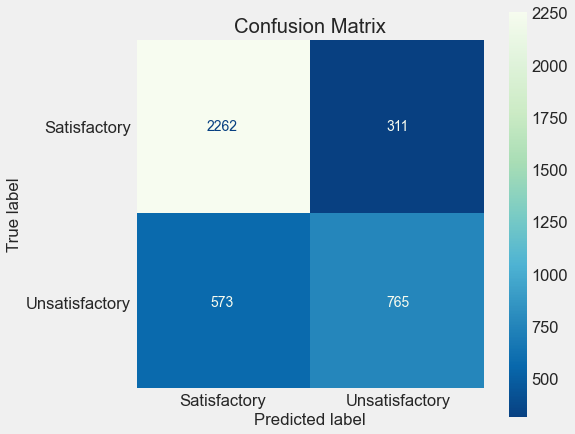

,Accuracy,F1,Recall,Precision
0,0.773971,0.633803,0.571749,0.710967


time: 732 ms


In [93]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [94]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.657744,0.000000,0.000000,0.000000,0.225856,Baseline DummyCFL
1,fsm,0.666184,0.287106,0.196513,0.535017,0.215852,FSM Naive Bayes
2,lsvc_ss,0.747336,0.564911,0.479203,0.688504,2.591510,Linear SVC SS()
3,logreg_ss,0.748274,0.573202,0.493898,0.683257,6.288537,LogReg SS()
4,knn_ss,0.722786,0.552786,0.500623,0.617213,4.235443,KNN SS()
5,svc_ss,0.758247,0.586729,0.501370,0.707273,21.937422,Support Vector CLF SS()
6,bclf_ss,0.761145,0.603987,0.532503,0.698086,11.107266,Bagging CLF SS()
7,rf_ss,0.766345,0.617163,0.550436,0.702744,9.838081,Random Forest SS()
8,dt_ss,0.691159,0.551961,0.556164,0.548288,1.828373,Decision Tree CLF SS()
9,ada_ss,0.692353,0.553249,0.556663,0.550191,1.870478,AdaBoost SS()


time: 11.3 ms


## SMOTE

## XGBoost SMOTE

In [95]:
xgb_sm = make_sm_pipeline(preprocessing_ss, sm, XGB)

time: 1.27 ms


### Fitting Model

In [96]:
%%capture --no-display
xgb_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('smote', SMOTE(random_state=2...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
       

time: 2.14 s


In [97]:
# f.pickle_model(xgb_sm, 'xgb_sm')

time: 940 µs


### Cross Val Scores

In [98]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_sm, X_train, y_train, 'xgb_sm',\
                'XGBoost SS()/SMOTE')

[0.7695840693403018, 0.64550178455247, 0.6129514321295144, 0.6817915763405379]

time: 8.37 s


### Test Data Confusion Matrix

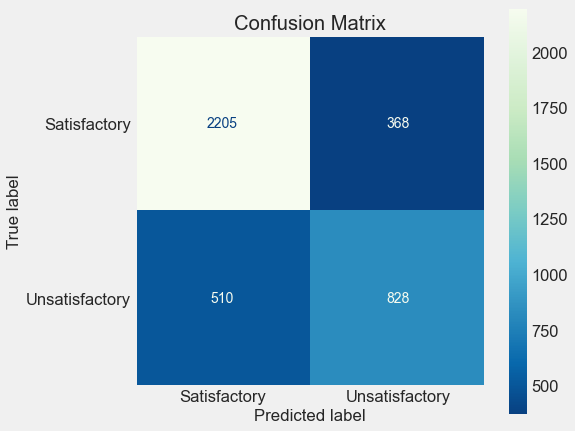

,Accuracy,F1,Recall,Precision
0,0.775505,0.653512,0.618834,0.692308


time: 364 ms


In [99]:
%%capture --no-display
f.confusion_report(xgb_sm, X_test, y_test)

## Voting CLF SMOTE

In [100]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [ ('bclf', clf1), ('rf', clf2), ('xgb', clf3)]
VC = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

time: 1.11 ms


In [101]:
vc_ss = make_sm_pipeline(preprocessing_ss, sm, VC)

time: 1.29 ms


### Fitting Model

In [102]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('smote', SMOTE(random_state=2...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
                    

time: 9.3 s


In [103]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 604 µs


### Cross Val Scores

In [104]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()/SMOTE SOFT')

[0.7691586110000215,
 0.6543042617645296,
 0.6383561643835616,
 0.6710982766348994]

time: 33.4 s


### Test Data Confusion Matrix

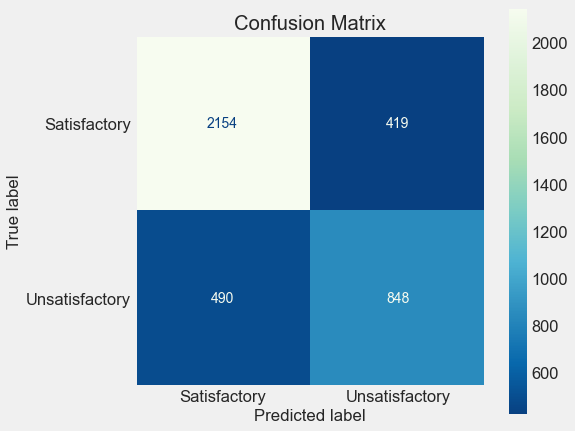

,Accuracy,F1,Recall,Precision
0,0.767579,0.651056,0.633782,0.669298


time: 786 ms


In [105]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [106]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.657744,0.000000,0.000000,0.000000,0.225856,Baseline DummyCFL
1,fsm,0.666184,0.287106,0.196513,0.535017,0.215852,FSM Naive Bayes
2,lsvc_ss,0.747336,0.564911,0.479203,0.688504,2.591510,Linear SVC SS()
3,logreg_ss,0.748274,0.573202,0.493898,0.683257,6.288537,LogReg SS()
4,knn_ss,0.722786,0.552786,0.500623,0.617213,4.235443,KNN SS()
5,svc_ss,0.758247,0.586729,0.501370,0.707273,21.937422,Support Vector CLF SS()
6,bclf_ss,0.761145,0.603987,0.532503,0.698086,11.107266,Bagging CLF SS()
7,rf_ss,0.766345,0.617163,0.550436,0.702744,9.838081,Random Forest SS()
8,dt_ss,0.691159,0.551961,0.556164,0.548288,1.828373,Decision Tree CLF SS()
9,ada_ss,0.692353,0.553249,0.556663,0.550191,1.870478,AdaBoost SS()


time: 13.8 ms


## Feature Importances

## XGBoost

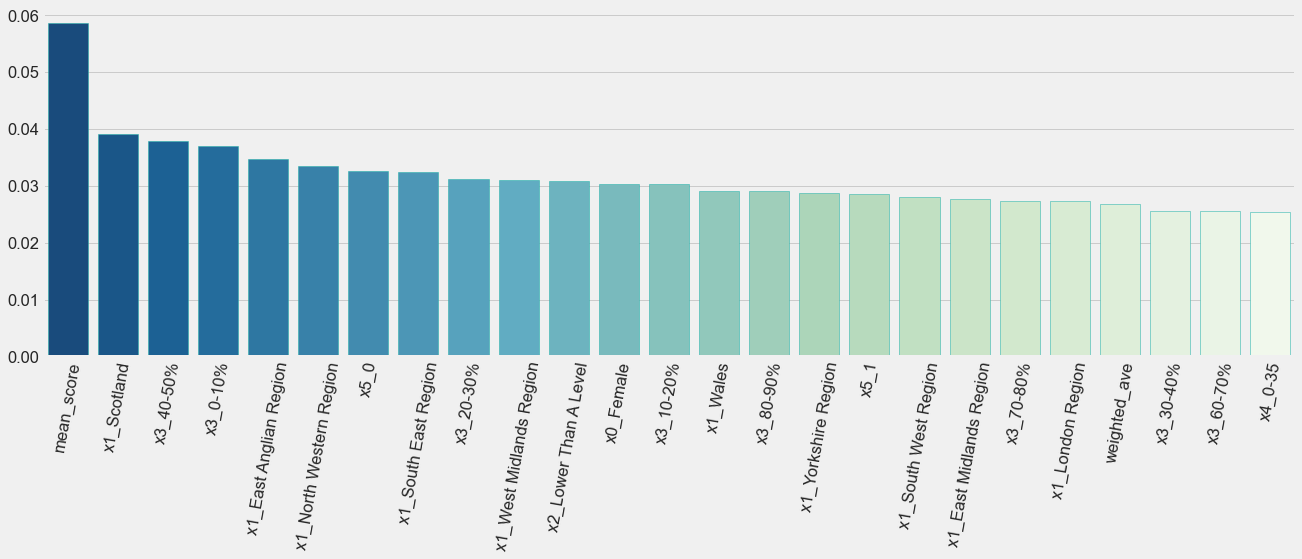

time: 352 ms


In [107]:
v.importance_plot_sm(xgb_sm, X_train)

In [108]:
# feature legend
keys = range(12)
f.get_features(keys, X_train)

0 gender
1 region
2 highest_education
3 imd_band
4 age_band
5 num_of_prev_attempts
6 disability
7 weighted_ave
8 mean_score
9 median_score
10 sum_activity
11 course_load
time: 1.56 ms


## Bagging Classifier

In [109]:
bclf_sm = make_sm_pipeline(preprocessing_ss, BCLF)
bclf_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.22 s


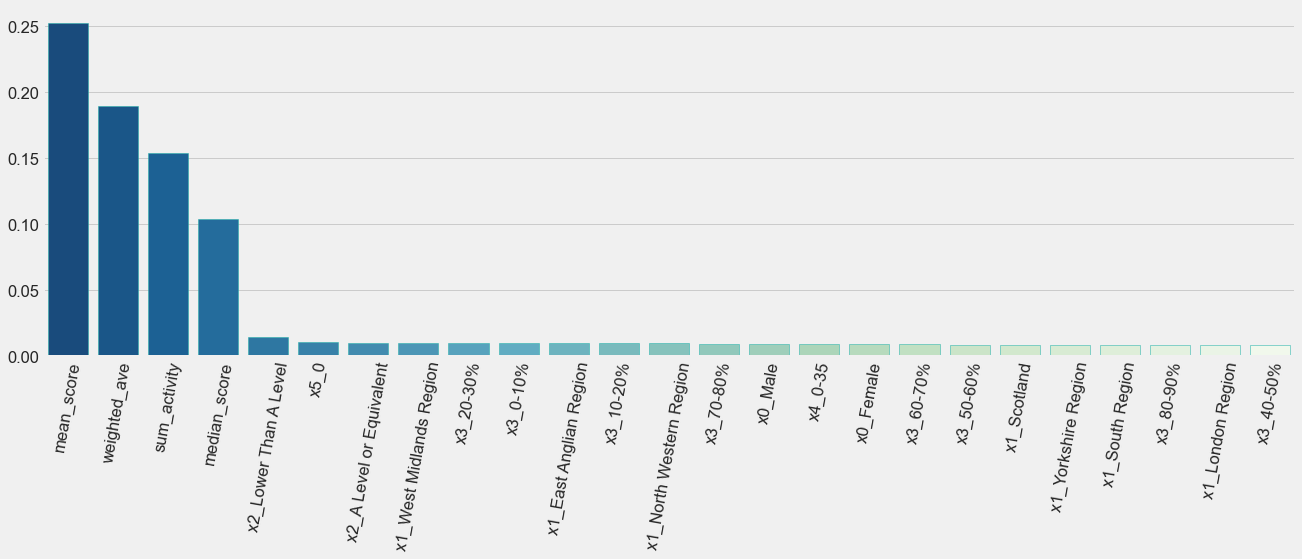

time: 328 ms


In [110]:
v.importance_plot_bclf(bclf_sm, X_train)

## Random Forest Classifier

In [111]:
rf_sm = make_sm_pipeline(preprocessing_ss, RF)
rf_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.2 s


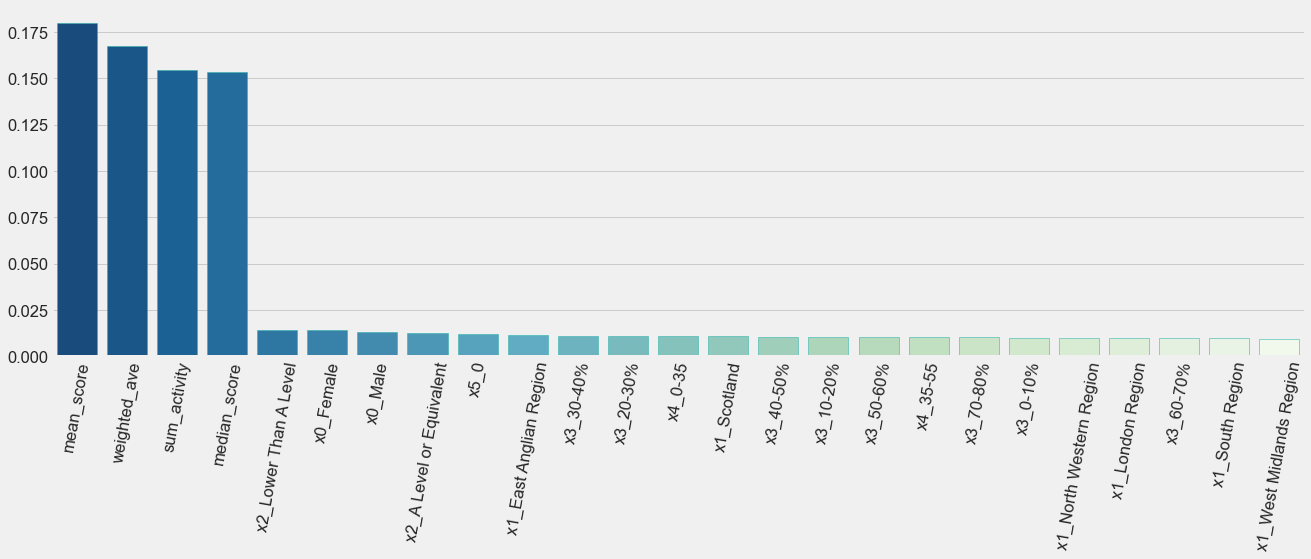

time: 487 ms


In [112]:
v.importance_plot(rf_sm, X_train)

## Permutation Importances

## Accuracy

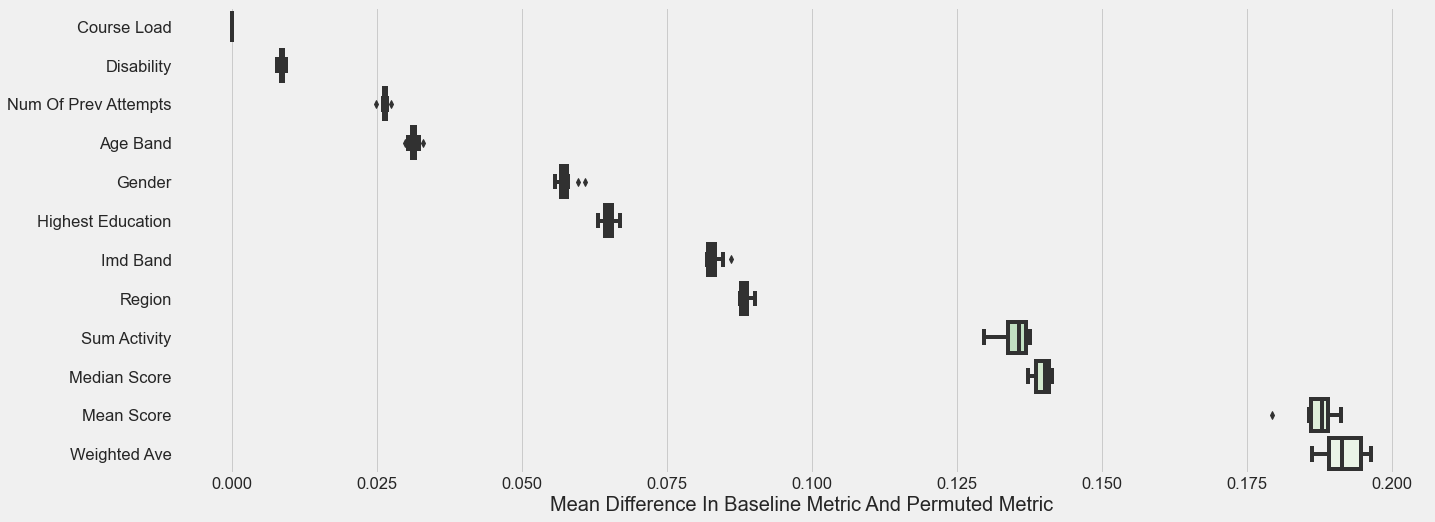

time: 20.4 s


In [113]:
f.perm_importances(vc_ss, X_train, y_train, 'accuracy')

## F1

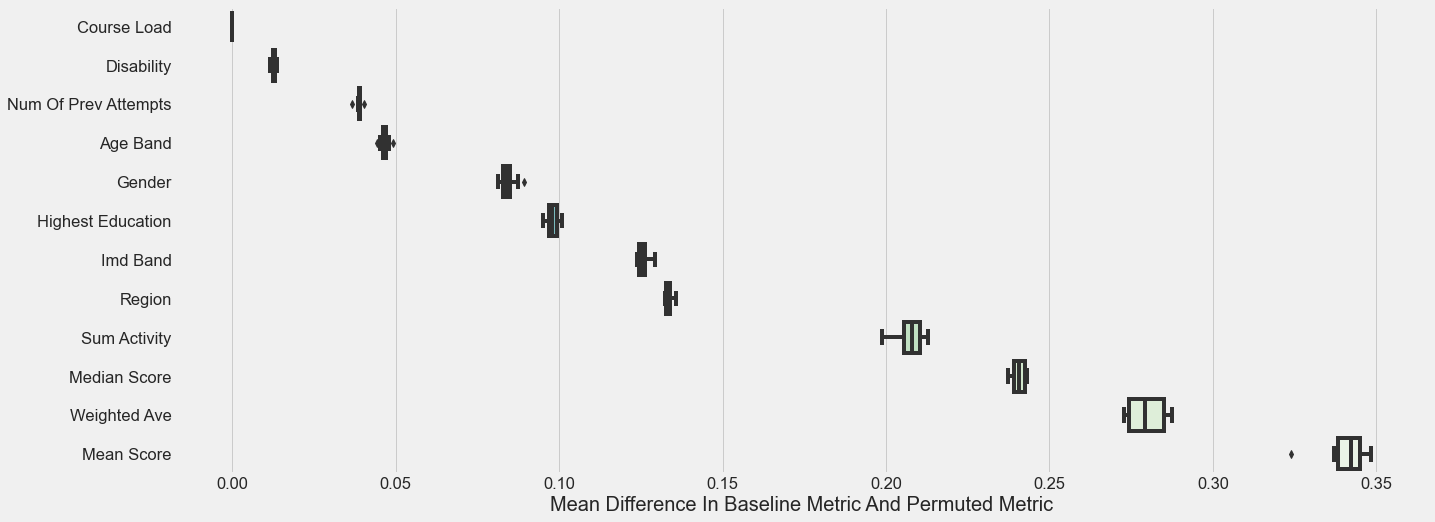

time: 23 s


In [114]:
f.perm_importances(vc_ss, X_train, y_train, 'f1')

## Recall

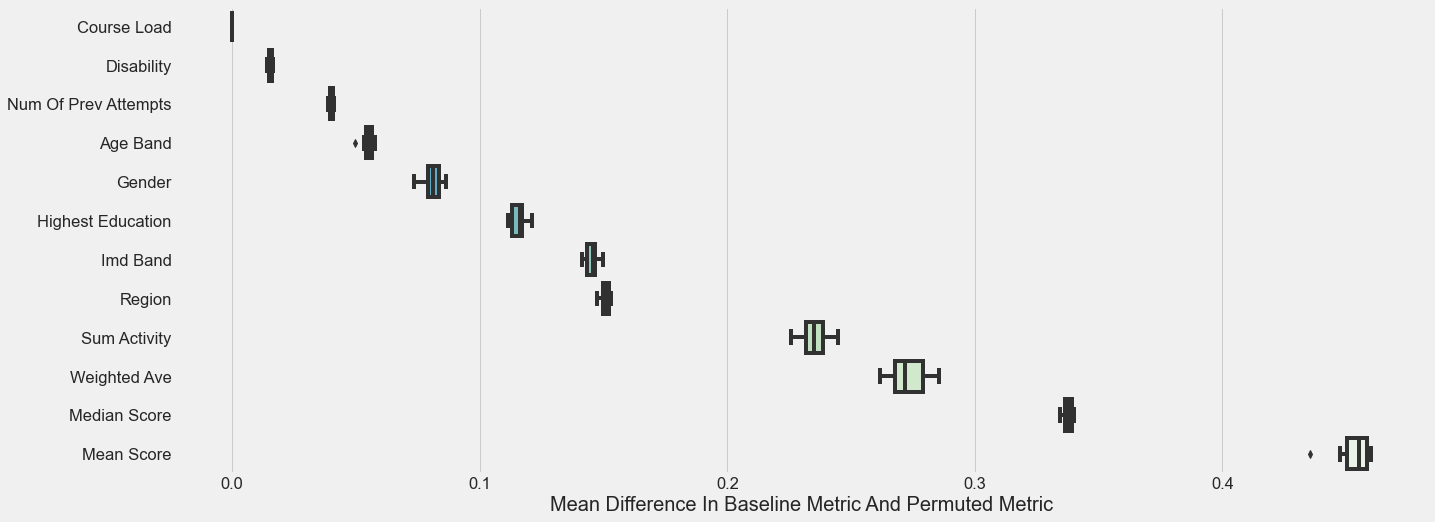

time: 22.9 s


In [115]:
f.perm_importances(vc_ss, X_train, y_train, 'recall')

## Precision

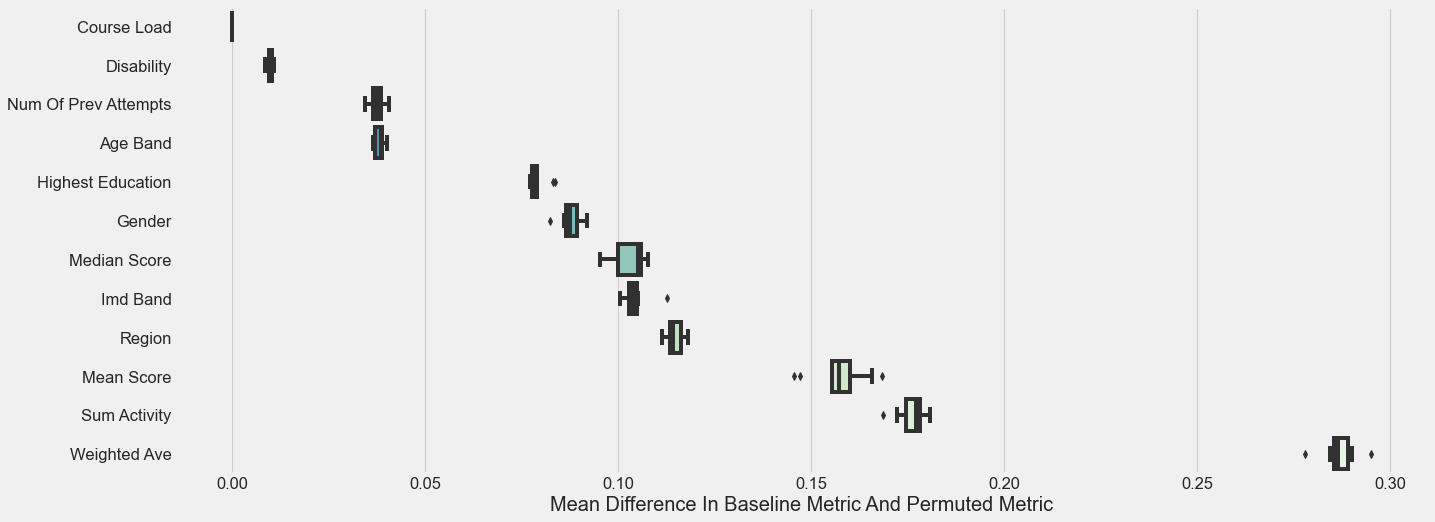

time: 22 s


In [116]:
f.perm_importances(vc_ss, X_train, y_train, 'precision')

In [117]:
vc_ss.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'smote', 'votingclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__onehotencoder', 'columntransformer__standardscaler', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'votingclassifier__estimators', 'votingclassifier__flatten_transform', 'votingclassifier__n_jobs', 'votingclassifier__verbose', 'votingclassifier__voting', 'votingclassifie

time: 5.05 ms


In [118]:
bag_params = ['votingclassifier__bclf__base_estimator__ccp_alpha', 
              'votingclassifier__bclf__base_estimator__class_weight',
              'votingclassifier__bclf__base_estimator__criterion', 
              'votingclassifier__bclf__base_estimator__max_depth', 
              'votingclassifier__bclf__base_estimator__max_features', 
              'votingclassifier__bclf__base_estimator__max_leaf_nodes', 
              'votingclassifier__bclf__base_estimator__min_impurity_decrease', 
              'votingclassifier__bclf__base_estimator__min_impurity_split', 
              'votingclassifier__bclf__base_estimator__min_samples_leaf', 
              'votingclassifier__bclf__base_estimator__min_samples_split', 
              'votingclassifier__bclf__base_estimator__min_weight_fraction_leaf', 
              'votingclassifier__bclf__base_estimator__random_state', 
              'votingclassifier__bclf__base_estimator__splitter', 
              'votingclassifier__bclf__base_estimator', 
              'votingclassifier__bclf__bootstrap', 
              'votingclassifier__bclf__bootstrap_features', 
              'votingclassifier__bclf__max_features', 
              'votingclassifier__bclf__max_samples',
              'votingclassifier__bclf__n_estimators', 
              'votingclassifier__bclf__n_jobs', 
              'votingclassifier__bclf__oob_score', 
              'votingclassifier__bclf__random_state', 
              'votingclassifier__bclf__verbose', 
              'votingclassifier__bclf__warm_start']

time: 2.01 ms


In [119]:
rf_params = ['votingclassifier__rf__bootstrap',
             'votingclassifier__rf__ccp_alpha', 
             'votingclassifier__rf__class_weight', 
             'votingclassifier__rf__criterion', 
             'votingclassifier__rf__max_depth', 
             'votingclassifier__rf__max_features', 
             'votingclassifier__rf__max_leaf_nodes', 
             'votingclassifier__rf__max_samples', 
             'votingclassifier__rf__min_impurity_decrease', 
             'votingclassifier__rf__min_impurity_split', 
             'votingclassifier__rf__min_samples_leaf', 
             'votingclassifier__rf__min_samples_split', 
             'votingclassifier__rf__min_weight_fraction_leaf', 
             'votingclassifier__rf__n_estimators', 
             'votingclassifier__rf__n_jobs', 
             'votingclassifier__rf__oob_score', 
             'votingclassifier__rf__random_state', 
             'votingclassifier__rf__verbose',
             'votingclassifier__rf__warm_start']

time: 1.82 ms


In [120]:
xgb_params = ['votingclassifier__xgb__objective', 
              'votingclassifier__xgb__use_label_encoder', 
              'votingclassifier__xgb__base_score', 
              'votingclassifier__xgb__booster', 
              'votingclassifier__xgb__colsample_bylevel', 
              'votingclassifier__xgb__colsample_bynode', 
              'votingclassifier__xgb__colsample_bytree', 
              'votingclassifier__xgb__gamma', 
              'votingclassifier__xgb__gpu_id', 
              'votingclassifier__xgb__importance_type', 
              'votingclassifier__xgb__interaction_constraints', 
              'votingclassifier__xgb__learning_rate', 
              'votingclassifier__xgb__max_delta_step', 
              'votingclassifier__xgb__max_depth', 
              'votingclassifier__xgb__min_child_weight', 
              'votingclassifier__xgb__missing', 
              'votingclassifier__xgb__monotone_constraints', 
              'votingclassifier__xgb__n_estimators', 
              'votingclassifier__xgb__n_jobs', 
              'votingclassifier__xgb__num_parallel_tree', 
              'votingclassifier__xgb__random_state', 
              'votingclassifier__xgb__reg_alpha', 
              'votingclassifier__xgb__reg_lambda', 
              'votingclassifier__xgb__scale_pos_weight', 
              'votingclassifier__xgb__subsample', 
              'votingclassifier__xgb__tree_method', 
              'votingclassifier__xgb__validate_parameters', 
              'votingclassifier__xgb__verbosity']

time: 2 ms


In [121]:
grid = {'votingclassifier__bclf__base_estimator__max_depth':\
        np.linspace(1, 32, 32),
        'votingclassifier__bclf__base_estimator__min_samples_split':\
        np.linspace(0.1, 1.0, 10),
        'votingclassifier__bclf__base_estimator__min_samples_leaf':\
        np.linspace(0.1, 0.5, 5),
        'votingclassifier__bclf__max_features':\
        list(range(1,X_train.shape[1])),
        'votingclassifier__rf__n_estimators':\
        np.linspace(1, 200, 20, dtype='int'),
        'votingclassifier__rf__max_depth':\
        np.linspace(1, 32, 32),
        'votingclassifier__rf__max_features':\
        list(range(1,X_train.shape[1])),
        'votingclassifier__rf__min_samples_leaf':\
        np.linspace(0.1, 0.5, 5),
        'votingclassifier__rf__min_samples_split':\
        np.linspace(0.1, 1.0, 10),
        'votingclassifier__xgb__n_estimators':\
        np.linspace(1, 200, 20, dtype='int'),
        'votingclassifier__xgb__colsample_bytree':\
        np.linspace(0.5, 1.0, 10),
        'votingclassifier__xgb__gamma':\
        np.linspace(0, .5, 5),
        'votingclassifier__xgb__learning_rate':\
        np.linspace(0.01, .5, 10),
        'votingclassifier__xgb__max_depth':\
        np.linspace(3, 10, 7, dtype='int'),
        'votingclassifier__xgb__reg_alpha':\
        np.logspace(.001, 2, 10),
        'votingclassifier__xgb__reg_lambda':\
        np.linspace(1, 10, 20)
       }

time: 2.5 ms


In [122]:
param_search = RandomizedSearchCV(vc_ss, param_distributions=grid,
                                  scoring='f1', random_state=2021, cv=3)

time: 1.3 ms


In [123]:
param_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0640>),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x15afe0970>...
                                        'votingclassifier__xgb__reg_alpha': array([  1.00230524,   1.67151821,   2.78754715,   4.64871941,
         7.75254765,  12.92872076, 

time: 46.1 s


In [124]:
search_results = pd.DataFrame(param_search.cv_results_)\
.sort_values(by='rank_test_score').reset_index(drop=True)

time: 6.38 ms


In [125]:
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_votingclassifier__xgb__reg_lambda,param_votingclassifier__xgb__reg_alpha,param_votingclassifier__xgb__n_estimators,param_votingclassifier__xgb__max_depth,param_votingclassifier__xgb__learning_rate,param_votingclassifier__xgb__gamma,...,param_votingclassifier__bclf__base_estimator__min_samples_split,param_votingclassifier__bclf__base_estimator__min_samples_leaf,param_votingclassifier__bclf__base_estimator__max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.995782,0.014187,0.069477,0.003978,3.842105,7.752548,21,10,0.173333,0.125,...,0.2,0.5,21.0,{'votingclassifier__xgb__reg_lambda': 3.842105...,0.660172,0.670446,0.638346,0.656321,0.013385,1
1,1.407239,0.022422,0.129603,0.002216,1.947368,21.560889,74,5,0.118889,0.25,...,0.9,0.4,20.0,{'votingclassifier__xgb__reg_lambda': 1.947368...,0.651644,0.668882,0.647407,0.655978,0.009287,2
2,0.763172,0.007318,0.055450,0.002644,7.157895,100.0,42,6,0.336667,0.25,...,0.2,0.3,27.0,{'votingclassifier__xgb__reg_lambda': 7.157894...,0.648192,0.662647,0.639294,0.650044,0.009623,3
3,1.277040,0.091656,0.090468,0.000188,5.263158,100.0,32,4,0.173333,0.375,...,0.3,0.1,31.0,{'votingclassifier__xgb__reg_lambda': 5.263157...,0.649454,0.649533,0.641801,0.646929,0.003626,4
4,0.922480,0.005697,0.059266,0.001767,1.947368,1.002305,84,3,0.445556,0.0,...,0.6,0.4,5.0,{'votingclassifier__xgb__reg_lambda': 1.947368...,0.651835,0.649074,0.634499,0.645136,0.007605,5


time: 24.4 ms


In [126]:
param_search.best_params_

{'votingclassifier__xgb__reg_lambda': 3.8421052631578947,
 'votingclassifier__xgb__reg_alpha': 7.75254765345907,
 'votingclassifier__xgb__n_estimators': 21,
 'votingclassifier__xgb__max_depth': 10,
 'votingclassifier__xgb__learning_rate': 0.17333333333333334,
 'votingclassifier__xgb__gamma': 0.125,
 'votingclassifier__xgb__colsample_bytree': 0.8888888888888888,
 'votingclassifier__rf__n_estimators': 53,
 'votingclassifier__rf__min_samples_split': 0.1,
 'votingclassifier__rf__min_samples_leaf': 0.5,
 'votingclassifier__rf__max_features': 4,
 'votingclassifier__rf__max_depth': 27.0,
 'votingclassifier__bclf__max_features': 4,
 'votingclassifier__bclf__base_estimator__min_samples_split': 0.2,
 'votingclassifier__bclf__base_estimator__min_samples_leaf': 0.5,
 'votingclassifier__bclf__base_estimator__max_depth': 21.0}

time: 3.55 ms


best_params_f1 =

{'votingclassifier__xgb__reg_lambda': 3.8421052631578947,
 'votingclassifier__xgb__reg_alpha': 7.75254765345907,
 'votingclassifier__xgb__n_estimators': 21,
 'votingclassifier__xgb__max_depth': 10,
 'votingclassifier__xgb__learning_rate': 0.17333333333333334,
 'votingclassifier__xgb__gamma': 0.125,
 'votingclassifier__xgb__colsample_bytree': 0.8888888888888888,
 'votingclassifier__rf__n_estimators': 53,
 'votingclassifier__rf__min_samples_split': 0.1,
 'votingclassifier__rf__min_samples_leaf': 0.5,
 'votingclassifier__rf__max_features': 4,
 'votingclassifier__rf__max_depth': 27.0,
 'votingclassifier__bclf__max_features': 4,
 'votingclassifier__bclf__base_estimator__min_samples_split': 0.2,
 'votingclassifier__bclf__base_estimator__min_samples_leaf': 0.5,
 'votingclassifier__bclf__base_estimator__max_depth': 21.0}
 
ACC 0.761953 F1 0.652223 RC 0.652466 PR 0.651979

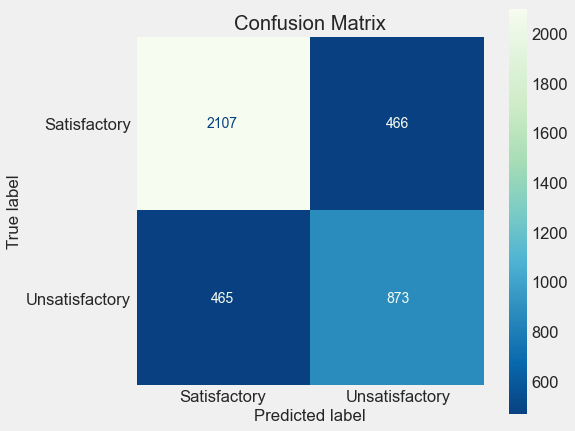

,Accuracy,F1,Recall,Precision
0,0.761953,0.652223,0.652466,0.651979


time: 597 ms


In [127]:
best_model = param_search.best_estimator_

f.confusion_report(best_model, X_test, y_test)

ACC 0.761953 F1 0.652223 RC 0.652466 PR 0.651979

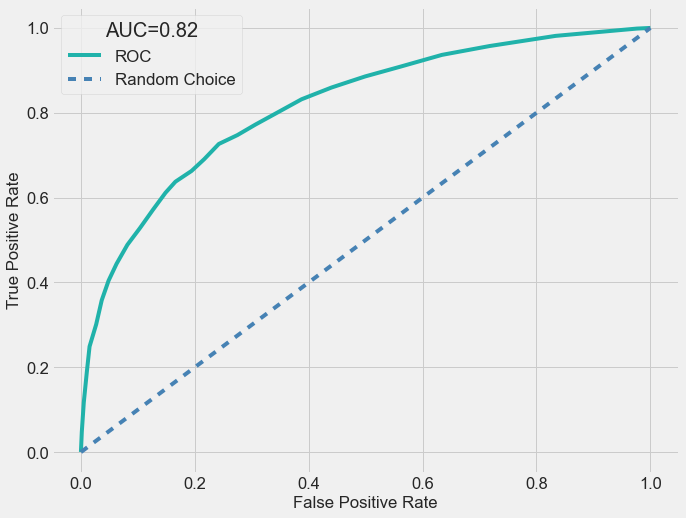

time: 828 ms


In [128]:
f.roc_auc(best_model, X_test, y_test)

In [129]:
%%capture --no-display
Audio(sound_file, autoplay=True)

time: 7.45 ms
